IEEE BigMM MultiModal Classification Challenge


**This Notebook involves more refined pre-processing of Tweets **


##Import All Libraries

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import io
pd.set_option('display.max_colwidth', -1)
! pip install -q scikit-plot
import scikitplot as skplt

import re
import os
import sys
import string
import time
import math
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
! pip install tweet-preprocessor

import unicodedata as uni
import nltk
from nltk.tokenize import TweetTokenizer
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from tqdm import tqdm

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, GRU, Conv1D,GRU
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.optimizers import Adam, RMSprop, Adamax
from keras.layers import MaxPooling2D,Activation,Dropout,Flatten,Dense,BatchNormalization

print(os.listdir("../"))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
['media', 'opt', 'srv', 'boot', 'home', 'etc', 'tmp', 'mnt', 'lib', 'sbin', 'proc', 'run', 'var', 'sys', 'dev', 'bin', 'root', 'lib64', 'usr', '.dockerenv', 'datalab', 'tools', 'swift', 'content', 'dlib-19.18.0-cp36-cp36m-linux_x86_64.whl', 'tensorflow-1.15.2', 'dlib-19.18.0-cp27-cp27mu-linux_x86_64.whl', 'lib32']


In [ ]:
ls

merged_tweets.txt  sample_data/  test.txt


##Train and Test Files upload, followed by multiple Pre-processings

In [ ]:
df = pd.read_csv("merged_tweets.txt")
df = df.drop(columns = ['Unnamed: 0'],axis=1)

flag_cols = ['Text_Only_Informative', 'Image_Only_Informative', 'Directed_Hate', 'Generalized_Hate', 'Sarcasm', 'Allegation', 'Justification', 
             'Refutation', 'Support', 'Oppose']
for i in flag_cols:
  df[i] = df[i].map({1.0: 1, 0.0: 0})
  df[i] = df[i].astype('uint8')

def normalise_text (text):
    text = text.str.lower() # lowercase
    text = text.str.replace(r"\\n"," ")
    text = text.str.replace(r"\\n\n"," ")
    text = text.str.replace(r"\n\n"," ")
    text = text.str.replace(r"\\\n\\n"," ")
    return text

In [ ]:
df["new_Tweets"]=normalise_text(df["Tweets"])
df.head(3)

,Tweets,TweetId,Text_Only_Informative,Image_Only_Informative,Directed_Hate,Generalized_Hate,Sarcasm,Allegation,Justification,Refutation,Support,Oppose,new_Tweets
0,"What a shock hey, Old Bill is in the clear &amp; every single #ImWithHer #MeToo moron will swallow this huge pile of shit without a single gag 🤷🏼‍♂️\n#Hypocrites https://t.co/xkYmFqnAnj",1051939199195045890,1,1,1,0,0,1,1,0,0,0,"what a shock hey, old bill is in the clear &amp; every single #imwithher #metoo moron will swallow this huge pile of shit without a single gag 🤷🏼‍♂️ #hypocrites https://t.co/xkymfqnanj"
1,"No Bucky, people are pissed off at ashleyperkins89 for attacking the credibility of an assault survivor AFTER THE ATTACKER, THOMAS RAVENEL, WAS ARRESTED AS THE RESULT OF A FOUR MONTH POLICE INVESTIGATION.\nThe only people questioning the #MeToo movement are men and rape enablers. https://t.co/YAQRgiVQb3",1050811961011838977,1,1,0,0,0,0,1,0,1,0,"no bucky, people are pissed off at ashleyperkins89 for attacking the credibility of an assault survivor after the attacker, thomas ravenel, was arrested as the result of a four month police investigation. the only people questioning the #metoo movement are men and rape enablers. https://t.co/yaqrgivqb3"
2,"If Sarah Hanson Young thinks #BrettKavanuagh is unfit for office, it’s hypocritical if she does not also think @billshortenmp who faced a similar allegation is not also unfit for office\n\n#auspol #sharrimarkson #metoo @SharriMarkson @SkyNewsAust @DavidLeyonhjelm @theboltreport https://t.co/KARD8o7j4f",1049930526314782720,1,1,0,0,0,0,0,0,1,0,"if sarah hanson young thinks #brettkavanuagh is unfit for office, it’s hypocritical if she does not also think @billshortenmp who faced a similar allegation is not also unfit for office #auspol #sharrimarkson #metoo @sharrimarkson @skynewsaust @davidleyonhjelm @theboltreport https://t.co/kard8o7j4f"


In [ ]:
print(df[["Tweets","new_Tweets"]].values[6])
# tweet_df.iloc[6]

['If Labor win Government what a #Quinella 🏇🏼🏇🏼\\n\\nPrime Minister - accused of historic rape allegation\\n\\nDeputy PM - married to convicted drug trafficker\\n\\n#auspol #metoo #Everest #Kavanaugh @AnnCoulter @theboltreport @J_C_Campbell @tomwconnell @sunriseon7 @annelisenews @couriermail https://t.co/H8JnMaz1ZC'
 'if labor win government what a #quinella 🏇🏼🏇🏼  prime minister - accused of historic rape allegation  deputy pm - married to convicted drug trafficker  #auspol #metoo #everest #kavanaugh @anncoulter @theboltreport @j_c_campbell @tomwconnell @sunriseon7 @annelisenews @couriermail https://t.co/h8jnmaz1zc']


In [ ]:
def analyze_tweet(tweet):
    result = {}
    result['MENTIONS'] = tweet.count('USER_MENTION')
    result['URLS'] = tweet.count('URL')
    result['POS_EMOS'] = tweet.count('EMO_POS')
    result['NEG_EMOS'] = tweet.count('EMO_NEG')
    tweet = tweet.replace('USER_MENTION', '').replace(
        'URL', '')
    words = tweet.split()
    result['WORDS'] = len(words)
    bigrams = get_bigrams(words)
    result['BIGRAMS'] = len(bigrams)
    return result, words, bigrams


def get_bigrams(tweet_words):
    bigrams = []
    num_words = len(tweet_words)
    for i in range(num_words - 1):
        bigrams.append((tweet_words[i], tweet_words[i + 1]))
    return bigrams


def get_bigram_freqdist(bigrams):
    freq_dict = {}
    for bigram in bigrams:
        if freq_dict.get(bigram):
            freq_dict[bigram] += 1
        else:
            freq_dict[bigram] = 1
    counter = Counter(freq_dict)
    return counter

In [ ]:
def preprocess_word(word):
    # Remove punctuation
    word = word.strip('\'"?!,.():;')
    # Convert more than 2 letter repetitions to 2 letter
    # funnnnny --> funny
    word = re.sub(r'(.)\1+', r'\1\1', word)
    # Remove - & '
    word = re.sub(r'(-|\')', '', word)
    return word


def is_valid_word(word):
    return (re.search(r'^[a-zA-Z][a-z0-9A-Z\._]*$', word) is not None)

def handle_emojis(tweet):
    # Smile -- :), : ), :-), (:, ( :, (-:, :')
    tweet = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\))', ' EMO_POS ', str(tweet))
    # Laugh -- :D, : D, :-D, xD, x-D, XD, X-D
    tweet = re.sub(r'(:\s?D|:-D|x-?D|X-?D)', ' EMO_POS ', str(tweet))
    # Love -- <3, :*
    tweet = re.sub(r'(<3|:\*)', ' EMO_POS ', str(tweet))
    # Wink -- ;-), ;), ;-D, ;D, (;,  (-;
    tweet = re.sub(r'(;-?\)|;-?D|\(-?;)', ' EMO_POS ', str(tweet))
    # Sad -- :-(, : (, :(, ):, )-:
    tweet = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:)', ' EMO_NEG ', str(tweet))
    # Cry -- :,(, :'(, :"(
    tweet = re.sub(r'(:,\(|:\'\(|:"\()', ' EMO_NEG ', str(tweet))
    return tweet

use_stemmer = False

def preprocess_tweet(tweet):
    processed_tweet = []
    # Convert to lower case
    tweet = tweet.lower()
    # Replaces URLs with the word URL
    tweet = re.sub(r"\\n","", str(tweet))
    tweet = re.sub(r"\n\n"," ", str(tweet))
    tweet = re.sub(r"\n","", str(tweet))
    tweet = re.sub(r'((www\.[\S]+)|(https?://[\S]+))', ' URL ', str(tweet))
    # Replace @handle with the word USER_MENTION
    tweet = re.sub(r'@[\S]+', 'USER_MENTION', str(tweet))
    # Replaces #hashtag with hashtag
    tweet = re.sub(r'#(\S+)', r' \1 ', str(tweet))
    # Remove RT (retweet)
    tweet = re.sub(r'\brt\b', '', str(tweet))
    # Replace 2+ dots with space
    tweet = re.sub(r'\.{2,}', ' ', str(tweet))
    # Strip space, " and ' from tweet
    tweet = tweet.strip(' "\'')
    # Replace emojis with either EMO_POS or EMO_NEG
    tweet = handle_emojis(tweet)
    # Replace multiple spaces with a single space
    tweet = re.sub(r'\s+', ' ', str(tweet))
    words = tweet.split()

    for word in words:
        word = preprocess_word(word)
        if is_valid_word(word):
            if use_stemmer:
                word = str(porter_stemmer.stem(word))
            processed_tweet.append(word)

    return ' '.join(processed_tweet)

In [ ]:
tweet_df = df[['new_Tweets']]
tweet_df.head(2)

,new_Tweets
0,"what a shock hey, old bill is in the clear &amp; every single #imwithher #metoo moron will swallow this huge pile of shit without a single gag 🤷🏼‍♂️ #hypocrites https://t.co/xkymfqnanj"
1,"no bucky, people are pissed off at ashleyperkins89 for attacking the credibility of an assault survivor after the attacker, thomas ravenel, was arrested as the result of a four month police investigation. the only people questioning the #metoo movement are men and rape enablers. https://t.co/yaqrgivqb3"


In [ ]:
K = []
L = list(tweet_df['new_Tweets'])
for i in range(len(L)):
  K.append(preprocess_tweet(L[i]))

In [ ]:
tweet_df['Processed_tweets'] = pd.DataFrame(K)
tweet_df.sample(2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,new_Tweets,Processed_tweets
596,"23 days, 6 hours, 24 minutes, 20 seconds and counting. vengeance is mine saith the scorned woman, now eat your vegetables, donald. @realdonaldtrump @jaketapper @chucktodd @johnkingcnn @johnavlon @johnberman @jeffreytoobin @amandacarpenter @maggienyt @cillizzacnn @niacnn #metoo https://t.co/vuak5ypndp",days hours minutes seconds and counting vengeance is mine saith the scorned woman now eat your vegetables donald USER_MENTION USER_MENTION USER_MENTION USER_MENTION USER_MENTION USER_MENTION USER_MENTION USER_MENTION USER_MENTION USER_MENTION USER_MENTION metoo URL
157,"chicago review has a #metoo poetry collective https://t.co/fz3mfn9beg \we want to thank the writers who have made such personal contributions...we want to offer our solidarity to them and to any of you,\"" wrote editors emily critchley and elizabeth-jane burnett #poetry @chireview https://t.co/orqzkcnj9c""",chicago review has a metoo poetry collective URL want to thank the writers who have made such personal contributions we want to offer our solidarity to them and to any of wrote editors emily critchley and elizabethjane burnett poetry USER_MENTION URL


In [ ]:
#Count of emojis

def cleaning_tweets(tweet):
    ''' Cleaning Tweets by tokenizing, converting to lowercase and converting EMOJI's to their string names'''
    words = [x for x in TweetTokenizer(strip_handles= True, preserve_case=False, reduce_len=True).tokenize(tweet) if x not in stopwords.words('english')]
    words = [x for x in words if x not in string.punctuation]
    emoji_count = 0
    for idx, word in enumerate(words):
        try:
            words[idx] = uni.name(word).lower()
            emoji_count += 1
        except:
            pass
    return words,emoji_count

def tweet_prep(tweets):
    '''
    Gets all tweets and cleans the tweets using cleaning_tweets. Returns a list of list of words in a tweet and a list of the number of emoji's in that tweet.
    Input: tweets: All tweets
    Output: tweets_list: list of list of words in each tweet
            emo_count: list of count of emoji's in each tweet
    '''
    tweets_list = []
    emo_count = []
    for tweet in tweets:
        words, count = cleaning_tweets(tweet)
        tweets_list.append(words)
        emo_count.append(count)
    #return tweets_list, emo_count
    return emo_count

In [ ]:
def feat(tweet_df):
    ment=[]
    url=[]
    #emo_counts = []
    pe=[]
    ne=[]
    bg=[]
    for i in range(len(tweet_df)):
        ment.append(analyze_tweet(tweet_df["Processed_tweets"].values[i])[0]['MENTIONS'])
        url.append(analyze_tweet(tweet_df["Processed_tweets"].values[i])[0]['URLS'])
        #emo_counts.append(cleaning_tweets(tweet_df["new_Tweets"].values[i]))
        pe.append(analyze_tweet(tweet_df["Processed_tweets"].values[i])[0]['POS_EMOS'])
        ne.append(analyze_tweet(tweet_df["Processed_tweets"].values[i])[0]['NEG_EMOS'])
        bg.append(analyze_tweet(tweet_df["Processed_tweets"].values[i])[0]['BIGRAMS'])

    tweet_df['mentions']=ment
    tweet_df['url']=url
    #tweet_df['emoji_counts']=emo_counts
    tweet_df['pos_em']=pe
    tweet_df['neg_em']=ne
    tweet_df['bigrams']=bg
    return tweet_df

In [ ]:
feat(tweet_df)
tweet_df.head(3)

In [ ]:
tweet_df['emoji_counts'] = tweet_prep(tweet_df["new_Tweets"])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
#Checking if the count of tweets is generated correctly
print(df["Tweets"].values[11])
tweet_df.iloc[11]

@dani_ries #metoo literally😂😂😂 https://t.co/S2f6Y2AvPQ


new_Tweets          @dani_ries #metoo literally😂😂😂 https://t.co/s2f6y2avpq
Processed_tweets    USER_MENTION metoo URL                                
mentions            1                                                     
url                 1                                                     
pos_em              0                                                     
neg_em              0                                                     
bigrams             0                                                     
emoji_counts        3                                                     
Name: 11, dtype: object

##Simple Classifiers [with above Pre-Processing]

In [ ]:
final_df = pd.concat([tweet_df[['Processed_tweets','mentions','url','pos_em','neg_em','bigrams']],df[['Text_Only_Informative', 'Image_Only_Informative', 'Directed_Hate', 'Generalized_Hate', 'Sarcasm',
                                                         'Allegation','Justification', 'Refutation', 'Support', 'Oppose']]],axis=1)
final_df.sample(3)

,Processed_tweets,mentions,url,pos_em,neg_em,bigrams,Text_Only_Informative,Image_Only_Informative,Directed_Hate,Generalized_Hate,Sarcasm,Allegation,Justification,Refutation,Support,Oppose
5359,amid sexual harassment allegations anu malik takes a break from indian idol read his statement URL anumalik metoo USER_MENTION indianidol10 URL,1,2,0,0,17,1,1,0,0,0,0,1,0,1,0
3427,rahuljohri coa split sharply over metoo action on bccis ceo rahul johri read URL URL,0,2,0,0,12,0,0,0,0,0,0,0,0,0,0
2934,metoo is not just a moment its a revolution that should have been come years ago in india because now timesup URL,0,1,0,0,20,1,0,1,0,0,0,0,0,1,0


###Cleaning up the Test Data just like Train 

In [ ]:
test_data = pd.read_csv("test.txt")

for i in range(len(test_data.tweets)):
    test_data['tweets'].iloc[i] = test_data['tweets'].iloc[i].replace('"', '')

test_data.head(2)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,tweet_id,tweets
0,1052098315687346177,Such insensitive words. But alll laughing and applauding including the woman anchor. #MeToo @dhanyarajendran https://t.co/AipLJ7pnyj
1,1052084623763591168,Be like Kali... Supporting through art for #MeToo #MeTooIndia moment https://t.co/8o991KymUb


In [ ]:
test_data["new_Tweets"]=normalise_text(test_data["tweets"])

K = []
L = list(test_data['new_Tweets'])
for i in range(len(L)):
  K.append(preprocess_tweet(L[i]))


test_data['Processed_tweets'] = pd.DataFrame(K)
test_data.sample(2)

,tweet_id,tweets,new_Tweets,Processed_tweets,mentions,url,pos_em,neg_em,bigrams
856,1050018356714201090,Looks like men aren't the only enemies females have in the work place...#AI now dislikes them as well!\nCome hear @Ella_M_Whelan strident views on the #Metoo movement this Nov Tix ➡️ https://t.co/zd6AMeHLRj\n https://t.co/79ou9HepF8 via @BIUK_Tech https://t.co/qAImnfvP3L,looks like men aren't the only enemies females have in the work place...#ai now dislikes them as well! come hear @ella_m_whelan strident views on the #metoo movement this nov tix ➡️ https://t.co/zd6amehlrj https://t.co/79ou9hepf8 via @biuk_tech https://t.co/qaimnfvp3l,looks like men arent the only enemies females have in the work place ai now dislikes them as well come hear USER_MENTION strident views on the metoo movement this nov tix URL URL via USER_MENTION URL,2,3,0,0,30
1355,1057245809098584064,Sochi Film Festival &amp; Awards Press Conference\n#MeToo @SochiFilmAwards\nDetails at #Fabuk Web: https://t.co/mVcxy1fprR https://t.co/s63jMD0Cv6,sochi film festival &amp; awards press conference #metoo @sochifilmawards details at #fabuk web: https://t.co/mvcxy1fprr https://t.co/s63jmd0cv6,sochi film festival awards press conference metoo USER_MENTION details at fabuk web URL URL,1,2,0,0,10


In [ ]:
feat(test_data)
# test_data['emoji_counts'] = tweet_prep(test_data["new_Tweets"])
test_data.sample(3)

,tweet_id,tweets,new_Tweets,Processed_tweets,mentions,url,pos_em,neg_em,bigrams
1015,1050814454764429312,@yamigautam Behind the scenes @filmfare #Elegant and #classy .#MeToo Yami should speak out https://t.co/R9DQTYuKWq,@yamigautam behind the scenes @filmfare #elegant and #classy .#metoo yami should speak out https://t.co/r9dqtyukwq,USER_MENTION behind the scenes USER_MENTION elegant and classy metoo yami should speak out URL,2,1,0,0,10
682,1052175013934182400,Animal prints are everywhere in all styles and colours check us out!\n\n#boutiqueanimalprint\n#metoo\n#likeforlike https://t.co/tthUhu2AWN,animal prints are everywhere in all styles and colours check us out! #boutiqueanimalprint #metoo #likeforlike https://t.co/tthuhu2awn,animal prints are everywhere in all styles and colours check us out boutiqueanimalprint metoo likeforlike URL,0,1,0,0,14
566,1051827733699805184,Yes we can survive this too 😣\n#MeToo https://t.co/kPiRJr1X8l,yes we can survive this too 😣 #metoo https://t.co/kpirjr1x8l,yes we can survive this too metoo URL,0,1,0,0,6


##NaiveBayes Classifier

In [ ]:
categories = ['Justification', 'Refutation', 'Support', 'Oppose']

#categories = ['Justification']
X_train_NB = train_X.Processed_tweets
X_val_NB = val_X.Processed_tweets
print(X_train_NB.shape)
print(X_val_NB.shape)

from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train_NB)
print('Shape using CountVectorizer():' , X_train_counts.shape)


from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
print('Shape using TfidfTransformer():' , X_train_tfidf.shape)

(4808,)
(2061,)
Shape using CountVectorizer(): (4808, 9689)
Shape using TfidfTransformer(): (4808, 9689)


In [ ]:
# Define a pipeline combining a text feature extractor with multi label classifier

from sklearn.feature_extraction.text import TfidfVectorizer
tvec = TfidfVectorizer()
# clf2 = LogisticRegression()
nb = MultinomialNB()
#svc = SVC()

model = Pipeline([('vectorizer',tvec)
                 ,('bernaulli_classifier',nb)
                 ])

for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    model.fit(X_train, train[category])
    # compute the testing accuracy
    prediction = model.predict(X_test)
    print('Test F1-Score using Bernaulli\'s NB is {}'.format(f1_score(test[category], prediction)))
    print('Validation F1-Score using naive_bayes: ', f1_score(test[category],prediction))
    print("Validation AUC-ROC Score: ", roc_auc_score(test[category],prediction))
    #print('Test Weighted F1-Score using Logistic is {}'.format(f1_score(test[category], prediction, average = 'weighted')))

... Processing Justification
Validation Accuracy using naive_bayes:  0.9665211062590975
Validation F1-Score using naive_bayes:  0.0
Validation AUC-ROC Score:  0.5


CONFUSION MATRIX:->


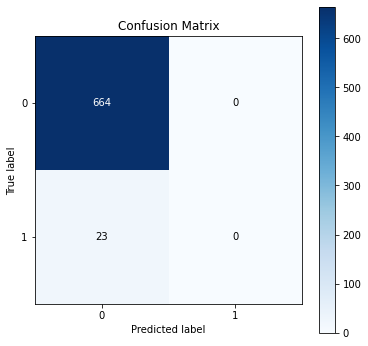

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
text_clf = Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer()),('clf', MultinomialNB()),])

for category in categories:
    print('... Processing {}'.format(category))
    text_clf.fit(X_train_NB, train_Y[category])
    # compute the validation accuracy
    prediction = text_clf.predict(X_val_NB)
    print("Validation Accuracy using naive_bayes: ", accuracy_score(val_Y[category],prediction))
    print('Validation F1-Score using naive_bayes: ', f1_score(val_Y[category],prediction))
    print("Validation AUC-ROC Score: ", roc_auc_score(val_Y[category],prediction))
    #Confusion Matrix
    print('\n')
    print('CONFUSION MATRIX:->')
    skplt.metrics.plot_confusion_matrix(val_Y[category],np.round(prediction),figsize=(6,6))

In [ ]:
embed_size = 500 
max_features = 1000
maxlen = 100

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(final_df.Processed_tweets))
new_train_X = tokenizer.texts_to_sequences(final_df.Processed_tweets)

## Pad the sentences
new_train_X = pad_sequences(new_train_X, maxlen=maxlen)

model_train_X = pd.concat([pd.DataFrame(new_train_X),final_df[['mentions','url', 'pos_em','neg_em','bigrams']].reset_index(drop=True)],axis=1)

model_train_X.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,mentions,url,pos_em,neg_em,bigrams
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,44,9,969,265,586,11,10,5,732,187,2,42,15,7,970,421,9,1,0,1,0,0,26
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,61,90,21,387,22,13,5,7,62,92,465,38,5,54,35,5,7,9,871,193,565,5,129,90,5,2,14,21,56,8,141,1,0,1,0,0,43


In [ ]:
#Same Processing for test data
embed_size = 500 
max_features = 1000
maxlen = 100

test_data_tokenizer = Tokenizer(num_words=max_features)
test_data_tokenizer.fit_on_texts(list(test_data.Processed_tweets))
new_test_X = tokenizer.texts_to_sequences(test_data.Processed_tweets)

## Pad the sentences
new_test_X = pad_sequences(new_test_X, maxlen=maxlen)

model_test_X = pd.concat([pd.DataFrame(new_test_X),test_data[['mentions','url', 'pos_em','neg_em','bigrams']].reset_index(drop=True)],axis=1)
model_test_X.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,mentions,url,pos_em,neg_em,bigrams
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,280,587,45,40,8,956,5,74,2,4,3,1,1,1,0,0,12
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24,77,502,341,434,13,2,26,121,1,0,1,0,0,9


##XGBoost Classifier

In [ ]:
import xgboost as xgb
categories = ['Text_Only_Informative', 'Image_Only_Informative','Directed_Hate', 'Generalized_Hate', 'Sarcasm', 'Allegation','Justification', 'Refutation', 'Support', 'Oppose']

pred = pd.DataFrame()
for category in categories:
  train_Y = final_df[category]
  #scale_pos_weights = sum(negative instances) / sum(positive instances)
  cls_weights = (len(final_df)-final_df[category].sum())/(final_df[category].sum())
  clf = xgb.XGBClassifier(scale_pos_weight =round(cls_weights,2))
  clf.fit(model_train_X,train_Y.values)
  xgb_pred = clf.predict(model_train_X)
  print('... Processing XGBoost Classifier for {}'.format(category))
  print("Train Accuracy: ", accuracy_score(train_Y.values,np.round(xgb_pred)))
  print("Train F1 Score: ", f1_score(train_Y.values,np.round(xgb_pred)))
  print("Train AUC-ROC Score: ", roc_auc_score(train_Y.values,np.round(xgb_pred)))
  pred[category] = clf.predict(model_test_X)

# #Confusion Matrix
# print('\n')
# print('CONFUSION MATRIX:->')
# skplt.metrics.plot_confusion_matrix(val_Y,np.round(xgb_pred),figsize=(6,6))

... Processing XGBoost Classifier for Text_Only_Informative
Train Accuracy:  0.6484204396564275
Train F1 Score:  0.7203890239666552
Train AUC-RUC Score:  0.6689667801077264
... Processing XGBoost Classifier for Image_Only_Informative
Train Accuracy:  0.6529334692094919
Train F1 Score:  0.569364161849711
Train AUC-RUC Score:  0.6633168959605471
... Processing XGBoost Classifier for Directed_Hate
Train Accuracy:  0.8194788178774203
Train F1 Score:  0.2592592592592593
Train AUC-RUC Score:  0.8314348866934544
... Processing XGBoost Classifier for Generalized_Hate
Train Accuracy:  0.8244285922259427
Train F1 Score:  0.22293814432989692
Train AUC-RUC Score:  0.8571122437159735
... Processing XGBoost Classifier for Sarcasm
Train Accuracy:  0.8465569951958073
Train F1 Score:  0.197869101978691
Train AUC-RUC Score:  0.8680077998447366
... Processing XGBoost Classifier for Allegation
Train Accuracy:  0.7609550152860678
Train F1 Score:  0.26499552372426144
Train AUC-RUC Score:  0.784553867798952


In [ ]:
final_preds = pd.concat([test_data,pred],axis=1)
final_preds.head(2)

,tweet_id,tweets,new_Tweets,Processed_tweets,mentions,url,pos_em,neg_em,bigrams,Text_Only_Informative,Image_Only_Informative,Directed_Hate,Generalized_Hate,Sarcasm,Allegation,Justification,Refutation,Support,Oppose
0,1052098315687346177,Such insensitive words. But alll laughing and applauding including the woman anchor. #MeToo @dhanyarajendran https://t.co/AipLJ7pnyj,such insensitive words. but alll laughing and applauding including the woman anchor. #metoo @dhanyarajendran https://t.co/aiplj7pnyj,such insensitive words but all laughing and applauding including the woman anchor metoo USER_MENTION URL,1,1,0,0,12,1,0,0,0,0,0,0,1,0,1
1,1052084623763591168,Be like Kali... Supporting through art for #MeToo #MeTooIndia moment https://t.co/8o991KymUb,be like kali... supporting through art for #metoo #metooindia moment https://t.co/8o991kymub,be like kali supporting through art for metoo metooindia moment URL,0,1,0,0,9,1,0,1,0,0,1,1,1,0,0


In [ ]:
final_sub.to_csv('sub1_xgboost_balanced.csv', index=False)

###XGBoost Classifier

... Processing for XGBoost Classifier:
Accuracy:  0.7438136826783115
Precision:  0.024844720496894408
Recall 0.17391304347826086
F1 Score:  0.043478260869565216
AUC-RUC Score:  0.4687336301728653


CONFUSION MATRIX:->


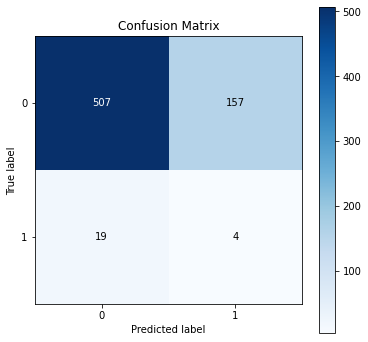

In [ ]:
import xgboost as xgb
#scale_pos_weights = sum(negative instances) / sum(positive instances)
clf = xgb.XGBClassifier(scale_pos_weight =28.9)
clf.fit(model_train_X,train_Y)
xgb_pred = clf.predict(model_val_X)
print('... Processing for XGBoost Classifier:')
print("Accuracy: ", accuracy_score(val_Y,np.round(xgb_pred)))
print("Precision: ", precision_score(val_Y,np.round(xgb_pred)))
print("Recall", recall_score(val_Y,np.round(xgb_pred)))
print("F1 Score: ", f1_score(val_Y,np.round(xgb_pred)))
print("AUC-RUC Score: ", roc_auc_score(val_Y,np.round(xgb_pred)))

#Confusion Matrix
print('\n')
print('CONFUSION MATRIX:->')
skplt.metrics.plot_confusion_matrix(val_Y,np.round(xgb_pred),figsize=(6,6))

##BiLSTM with Adam Optimizer using dropout [to avoid overfitting]

In [ ]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# Callbacks
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=2, mode='max')
#early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=2, mode='min')

def get_model():
    embed_size = 64
    #100 text features+6 derived features
    maxlen=106
    inp = Input(shape=(maxlen, ))
    x = Embedding(max_features, embed_size)(inp)
    x = Bidirectional(LSTM(50, return_sequences=True))(x)
    x = GlobalMaxPool1D()(x)
    x = Dropout(0.1)(x)
    x = Dense(50, activation="relu")(x)    
    x = Dropout(0.1)(x)
    x = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

model1 = get_model()

from matplotlib import pyplot
history = model1.fit(model_train_X,train_Y, batch_size=32, epochs=10, validation_data=(model_val_X, val_Y),callbacks=[lr_reduce])

pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('Model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

... Processing for BiLSTM Model with Dropout and Adam Optimizer:
Accuracy:  0.9665211062590975
Precision:  0.0
Recall 0.0
F1 Score:  0.0
AUC-RUC Score:  0.5


CONFUSION MATRIX:->


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


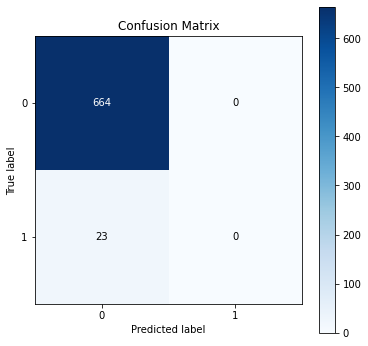

In [ ]:
#Predictions
from sklearn.metrics import confusion_matrix
print('... Processing for BiLSTM Model with Dropout and Adam Optimizer:')
pred = model1.predict(model_val_X)

#Scores using BiLSTM Model
print("Accuracy: ", accuracy_score(val_Y,np.round(pred)))
print("Precision: ", precision_score(val_Y,np.round(pred)))
print("Recall", recall_score(val_Y,np.round(pred)))
print("F1 Score: ", f1_score(val_Y,np.round(pred)))
print("AUC-RUC Score: ", roc_auc_score(val_Y,np.round(pred)))

#Confusion Matrix
print('\n')
print('CONFUSION MATRIX:->')
skplt.metrics.plot_confusion_matrix(val_Y,np.round(pred),figsize=(6,6))